In [120]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro

# Importing my custom transformers
from src.features.transformer_classes import (
    LowerCaseColumnsTransformer,
    BinaryColumnsTransformer,
    FillNATransformers,
    DropNATransformers,
    CounterColumnsTransformer,
    DateColumnsTransformer,
    ArithmeticColumnTransformer,
    DropColumnsTransformer,
    DataframeFilterTransformer,
    CreateTargetColumns,
    DropColumnsTransformer,
)

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
# print(os.getcwd())

/Users/matheus/Projects/steam_analysis/steam-analysis/notebooks/analysis


In [4]:
# os.chdir("../..")

In [6]:
steam_df = pd.read_csv("data/raw/games.csv")

Listing the columns I want to keep for analysis. This will be the argument for one of the transformers in the Pipeline.

In [7]:
columns_to_exlude = list(
    steam_df[
        steam_df.columns.difference(
            [
                "Achievements",
                "about_length",
                "n_screens",
                "n_movies",
                "n_tags",
                "n_languages",
                "has_publisher",
                "perceived_quality",
                "has_support_email",
                "has_support_url",
                "has_website",
                "random_noise",
            ]
        )
    ].columns
)

In [9]:
columns_to_exlude = [col.lower().replace(" ", "_") for col in columns_to_exlude]

In [11]:
pipeline = Pipeline(
    steps=[
        ("lowercase_columns", LowerCaseColumnsTransformer()),
        (
            "create_binary_columns",
            BinaryColumnsTransformer(
                columns=["publishers", "support_email", "support_url", "website"]
            ),
        ),
        ("fill_NA_columns", FillNATransformers(columns=["tags", "about_the_game"])),
        (
            "drop_na_columns",
            DropNATransformers(columns=["screenshots", "movies", "genres"]),
        ),
        (
            "create_counter_columns",
            CounterColumnsTransformer(
                ["tags", "screenshots", "movies", "supported_languages"]
            ),
        ),
        ("create_date_columns", DateColumnsTransformer("release_date")),
        (
            "create_total_reviews_columns",
            ArithmeticColumnTransformer("positive", "negative", "add", "total_reviews"),
        ),
        (
            "create_perceived_quality_columns",
            ArithmeticColumnTransformer(
                "positive", "negative", "truediv", "perceived_quality"
            ),
        ),
        ("create_target_columns", CreateTargetColumns(threshold=500)),
        (
            "filter_dataframe",
            DataframeFilterTransformer(
                filter_dict={
                    "metacritic_score": 0,
                    "total_reviews": 0,
                    "year": 2020,
                    "genres": "Indie",
                }
            ),
        ),
        ("drop_columns", DropColumnsTransformer(columns_to_exlude)),
    ]
)

In [13]:
transformed_steam_df = pipeline.fit_transform(steam_df)

## Analysis

Our main goal is analyzing the data and looking for differences between games that are successful and games that are not. We have to be careful, though. Simply stating that there is a difference in the median value of a variable between two distributions is not enough to affirm that this difference is statistically significant.

In [121]:
transformed_steam_df.groupby(by="target_success").median()

,achievements,has_publishers,has_support_email,has_support_url,has_website,n_tags,n_screenshots,n_movies,n_supported_languages,month,day,year,total_reviews,perceived_quality
target_success,,,,,,,,,,,,,,
False,2.0,1.0,1.0,0.0,0.0,13.0,7.0,1.0,1.0,7.0,16.0,2022.0,4.0,1.000000
True,19.0,1.0,1.0,1.0,1.0,20.0,10.0,2.0,5.0,6.0,16.0,2021.0,1264.0,7.514469


In [47]:
transformed_steam_df.groupby(by="target_success").describe()

achievements                                              \
                      count       mean        std  min  25%   50%   75%   
target_success                                                            
False               31488.0  11.567518  45.080952  0.0  0.0   2.0  15.0   
True                 1171.0  29.562767  47.599775  0.0  0.0  19.0  38.0   

                         n_tags                                              \
                   max    count       mean       std  min   25%   50%   75%   
target_success                                                                
False           5394.0  31488.0  11.373698  8.174906  1.0   1.0  13.0  20.0   
True             636.0   1171.0  18.539710  3.219983  5.0  20.0  20.0  20.0   

                     n_screenshots                                             \
                 max         count       mean       std  min  25%   50%   75%   
target_success                                                                  
False           21.0       31488.0   8.517626  5.108280  1.0  5.0   7.0  10.0   
True            21.0        1171.0  11.755764  7.428758  4.0  7.0  10.0  14.0   

                      n_movies                                                \
                  max    count      mean       std  min  25%  50%  75%   max   
target_success                                                                 
False           140.0  31488.0  1.340352  0.808878  1.0  1.0  1.0  1.0  19.0   
True            111.0   1171.0  2.029035  1.320131  1.0  1.0  2.0  3.0  13.0   

               n_supported_languages                                      \
                               count      mean        std  min  25%  50%   
target_success                                                             
False                        31488.0  4.119919  10.661009  1.0  1.0  1.0   
True                          1171.0  6.596926   6.055283  1.0  1.0  5.0   

                               month                                           \
                 75%    max    count      mean       std  min  25%  50%   75%   
target_success                                                                  
False            3.0  103.0  31488.0  6.703220  3.461339  1.0  4.0  7.0  10.0   
True            11.0   29.0   1171.0  6.325363  3.386378  1.0  3.0  6.0   9.0   

                          day                                             \
                 max    count       mean       std  min  25%   50%   75%   
target_success                                                             
False           12.0  31488.0  15.984915  8.922187  1.0  8.0  16.0  24.0   
True            12.0   1171.0  15.509821  8.614172  1.0  8.0  16.0  23.0   

                         year                                                 \
                 max    count         mean       std     min     25%     50%   
target_success                                                                 
False           31.0  31488.0  2021.659553  1.112762  2020.0  2021.0  2022.0   
True            31.0   1171.0  2020.988044  1.001637  2020.0  2020.0  2021.0   

                               total_reviews                             \
                   75%     max         count         mean           std   
target_success                                                            
False           2023.0  2024.0       31488.0    25.560595     62.066873   
True            2022.0  2024.0        1171.0  5129.539710  21274.705266   

                                                       perceived_quality  \
                  min    25%     50%     75%       max             count   
target_success                                                             
False             1.0    1.0     4.0    18.0     500.0           31488.0   
True            503.0  733.0  1264.0  2994.0  454800.0            1171.0   

                                                                              \
                     mean     

In [29]:
success_df = transformed_steam_df[transformed_steam_df["target_success"] == True]
failure_df = transformed_steam_df[transformed_steam_df["target_success"] == False]

Let us better understand our distributions before testing them.

In [111]:
def plot_distributions(df1, df2):
    plt.figure(figsize=(15, 20))
    columns = df1.columns

    for i, column in enumerate(columns, 1):
        plt.subplot(len(columns), 2, 2 * i - 1)
        sns.boxplot(df1[column], showfliers=False)
        plt.title(f"Distribution of {column} in Dataset 1")

        plt.subplot(len(columns), 2, 2 * i)
        sns.boxplot(df2[column], showfliers=False)
        plt.title(f"Distribution of {column} in Dataset 2")

    plt.tight_layout()
    plt.show()

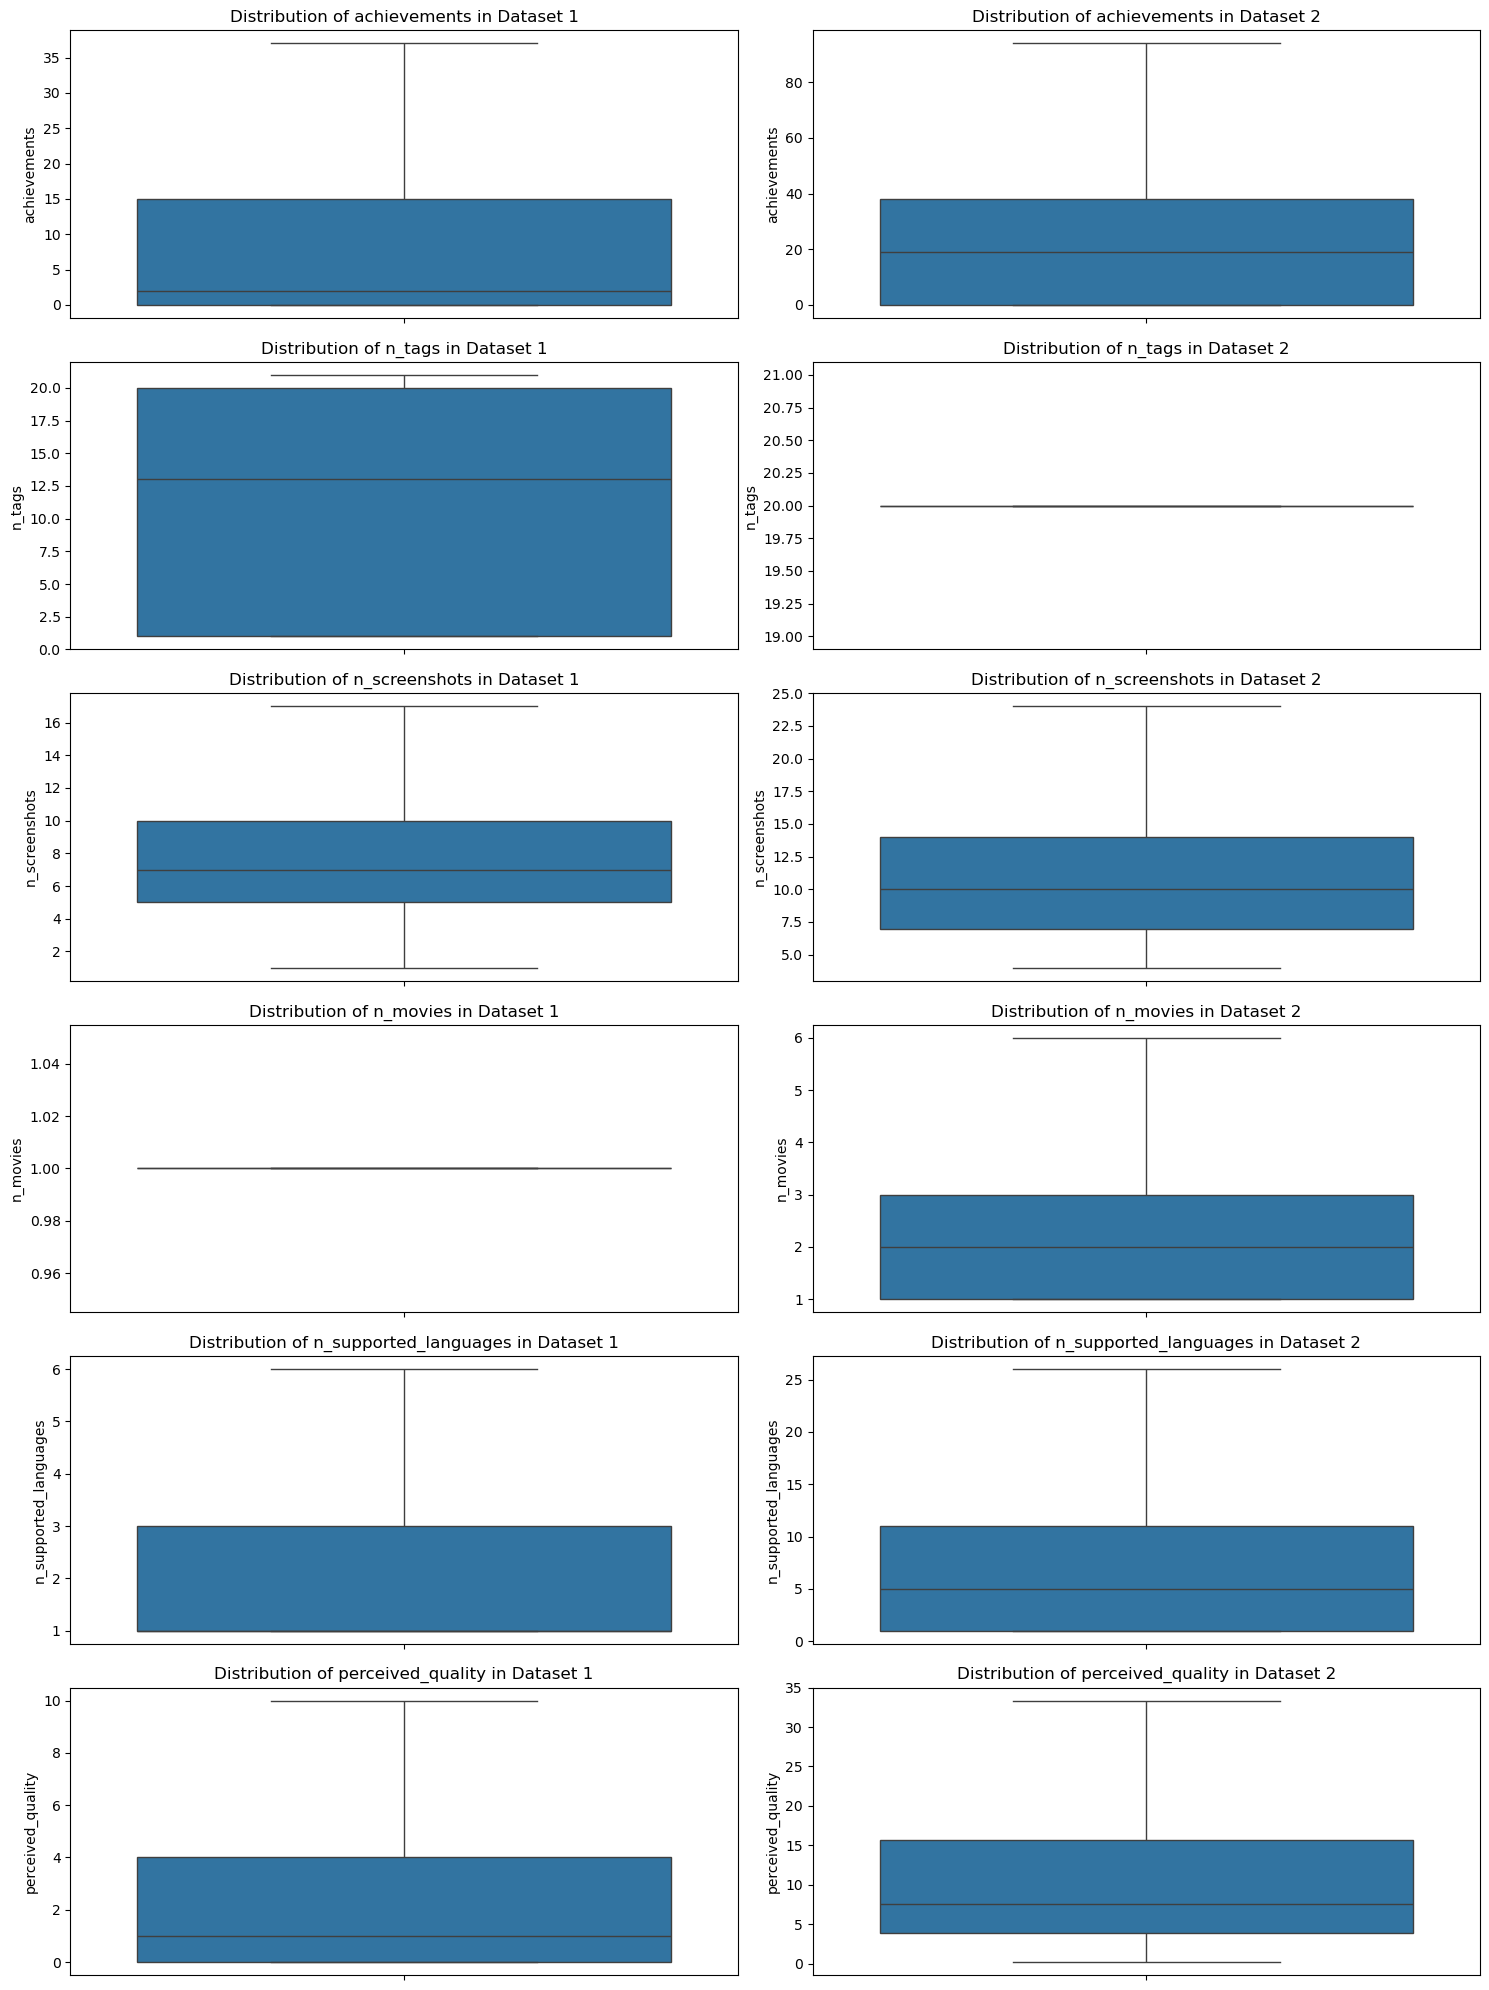

In [119]:
plot_distributions(
    failure_df[
        [
            "achievements",
            "n_tags",
            "n_screenshots",
            "n_movies",
            "n_supported_languages",
            "perceived_quality",
        ]
    ],
    success_df[
        [
            "achievements",
            "n_tags",
            "n_screenshots",
            "n_movies",
            "n_supported_languages",
            "perceived_quality",
        ]
    ],
)

A very quick visualization of the distributions for our sample will show us that they are non-normal (and very long tailed if we take the outliers in consideration). Because of this, we have to be careful when choosing statistical tests, since many of them assume a normal distribution. We can also use tests for normality, as we do bellow. 

In [113]:
def test_normality(df):
    normality_results = {}
    for column in df.columns:
        stat, p_value = shapiro(df[column])
        normality_results[column] = {
            "statistic": stat,
            "p_value": p_value,
            "normal": p_value > 0.05,
        }

    return normality_results

In [118]:
pd.DataFrame(test_normality(transformed_steam_df))

/Users/matheus/miniconda3/envs/steam-analysis/lib/python3.12/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,achievements,has_publishers,has_support_email,has_support_url,has_website,n_tags,n_screenshots,n_movies,n_supported_languages,month,day,year,total_reviews,perceived_quality,target_success
statistic,0.151327,0.016423,0.308133,0.627375,0.610893,0.782419,0.657323,0.481184,0.300536,0.93875,0.95422,0.867015,0.020638,0.450928,0.179682
p_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Knowing that we are not dealing with data that is normally distributed, we choose Mann-Whitney U test for our task. This an non-parametric equivalent of a T test. Let us state our null-hypothesis clearly:

#### Null hypothesis: For randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.

#### Alternative hypothesis: The distribution underlying x is stochastically less than the distribution underlying y, i.e. F(u) > G(u) for all u.

In [66]:
# Function to perform pairwise Mann-Whitney U Test
def pairwise_mannwhitneyu(df1, df2, alternative):
    results = {}
    for column in df1.columns:
        if column in df2.columns:
            stat, p = mannwhitneyu(df1[column], df2[column], alternative=alternative)
            results[column] = {"statistic": stat, "p-value": p}
    return pd.DataFrame(results).T

In [95]:
results = pairwise_mannwhitneyu(
    failure_df[
        [
            "achievements",
            "n_tags",
            "n_screenshots",
            "n_movies",
            "n_supported_languages",
            "perceived_quality",
        ]
    ],
    success_df[
        [
            "achievements",
            "n_tags",
            "n_screenshots",
            "n_movies",
            "n_supported_languages",
            "perceived_quality",
        ]
    ],
    "less",
)
print(results)

                        statistic        p-value
achievements           12239467.0   7.333185e-96
n_tags                  8905720.0  5.331605e-214
n_screenshots          11588489.0  4.767893e-107
n_movies               12200310.5  7.802558e-154
n_supported_languages  11304783.0  1.562396e-139
perceived_quality       6288539.0   0.000000e+00


All p-values are basically 0. We can reject our null-hypothesis in favor of our alternative hypothesis. Knowing that for all these columns the underlying distribution for our 'failure_df' df is stochastically less than the distribution for our 'sucess_df' isn't telling us anything about the size of this effect. 
We can calculate the size effect in a simple way by using the 'Common language effect size'. Since the U statistic is basically a measure of how many times did an item in X1 was bigger than an item in X2, we can divide this by the total number of possible combinations of items in both distribution and derive a probability of the value sampled from one distribution being bigger than a value sampled from the second distribution. 


In [84]:
for n, u in enumerate(results["statistic"]):
    n1 = len(failure_df)
    n2 = len(success_df)
    CL = u / (n1 * n2)
    print(f"CL_{results['statistic'].index[n]} = {CL}")

CL_achievements = 0.33194072170092964
CL_n_tags = 0.2415277662063555
CL_n_screenshots = 0.3142858591867836
CL_n_movies = 0.3308787770207175
CL_n_supported_languages = 0.3065916046583075
CL_perceived_quality = 0.17054845395673213


Now we can proceed to write a report that is more statistically sound. 